In [1]:
## Get trial level theta

In [1]:
import matplotlib
# matplotlib.use("Qt5Agg")
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import signal, stats
import mat73
import re
from neurodsp.timefrequency import compute_wavelet_transform
from BCI2kReader import BCI2kReader as b2k
import os
import mne
from tabulate import tabulate
import IPython
import seaborn as sns
import scipy
import joblib
import random
import statsmodels
from statsmodels import stats
from statsmodels.stats import multitest

# Import required code for visualizing example models
from fooof import FOOOF
from fooof.sim.gen import gen_power_spectrum
from fooof.sim.utils import set_random_seed
from fooof.plts.spectra import plot_spectra
from fooof.plts.annotate import plot_annotated_model
import neurodsp as ndsp



In [2]:
## Prep paths ##

subject = 'SLCH002'
raw_data_dir = f"/home/brooke/pacman/raw_data/{subject}"
preproc_data_dir = f"/home/brooke/pacman/preprocessing/{subject}/ieeg"

In [3]:
## Load Neural Data

# load
last_away_ecpohs = mne.read_epochs(f"{preproc_data_dir}/{subject}_bp_raw_clean_last_away_events.fif")

# get good epochs (for behavioral data only)
good_epochs = [i for i,x in enumerate(last_away_ecpohs.get_annotations_per_epoch()) if not x]
bad_epochs = [i for i,x in enumerate(last_away_ecpohs.get_annotations_per_epoch()) if  x]

# onlt good epochs
last_away_ecpohs = last_away_ecpohs[good_epochs]

# load behavioral data
last_away_data = pd.read_csv(f"{raw_data_dir}/behave/{subject}_last_away_events.csv")

## Prep Behavioral Data
last_away_data['trial_numeric'] = last_away_data['trial_numeric'] - 1
last_away_data = last_away_data[last_away_data.index.isin(good_epochs)]

# set info as metadata
last_away_ecpohs.metadata = last_away_data

Reading /home/brooke/pacman/preprocessing/SLCH002/ieeg/SLCH002_bp_raw_clean_last_away_events.fif ...


/tmp/ipykernel_30457/870373520.py:4: RuntimeWarning: This filename (/home/brooke/pacman/preprocessing/SLCH002/ieeg/SLCH002_bp_raw_clean_last_away_events.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  last_away_ecpohs = mne.read_epochs(f"{preproc_data_dir}/{subject}_bp_raw_clean_last_away_events.fif")


    Found the data of interest:
        t =   -5000.00 ...    5000.00 ms
        0 CTF compensation matrices available
Reading /home/brooke/pacman/preprocessing/SLCH002/ieeg/SLCH002_bp_raw_clean_last_away_events-1.fif ...
    Found the data of interest:
        t =   -5000.00 ...    5000.00 ms
        0 CTF compensation matrices available
0 bad epochs dropped
0 bad epochs dropped
Not setting metadata
223 matching events found
No baseline correction applied
0 projection items activated
Adding metadata with 5 columns


In [4]:
last_away_data[0:20]

,trial_numeric,TrialType,sample,sample_before,event
0,0,8,39400,0,1
1,1,12,59400,0,1
2,2,3,71000,0,1
3,3,7,89600,0,1
4,4,16,110400,0,1
5,5,2,126000,0,1
6,6,10,143200,0,1
8,8,17,174200,0,1
10,11,5,207600,0,1
11,12,19,222600,0,1


In [5]:
# separate ghost and no ghost trials

ghost_epochs = last_away_ecpohs["TrialType <= 16"]
no_ghost_epochs = last_away_ecpohs["TrialType > 16"]

In [6]:
ghost_epochs

Number of events,143
Events,1: 143
Time range,-5.000 – 5.000 sec
Baseline,off


In [7]:
## Dictionary of electrode locations ##

# i3', 'i4', 'i5', 'i6', 'i7', 'K2', 'K3', 'K4', 'K5', 'K6', 'J4', 'J5', 'J6'],

ROIs = {
    'hc'     :['K2', 'K3', 'K4', 'K5', 'K6', 'J4', 'J5', 'J6'],
    'ofc'    :['A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A16'],
    'amyg'   :['i1', 'i2', 'i3', 'i4', 'i5', 'i6', 'i7'],
    'insula' :[],
    'cing'   :['A1', 'A2', 'A3', 'A4']
}

hc_list = []
hc_indices = []
hc_names = []
ofc_list = []
ofc_indices = []
ofc_names = []
amyg_list = []
amyg_names = []               
insula_list = []
insula_names = []            
cing_list = []
cing_names = []               
pairs_long_name = [ch.split('-') for ch in last_away_ecpohs.info['ch_names']]
bidx = len(last_away_ecpohs.info['bads']) +1
pairs_name = pairs_long_name[bidx:len(pairs_long_name)]

for ix in range(1, len(pairs_name)):
    if pairs_name[ix][0] in ROIs['hc'] or pairs_name[ix][1] in ROIs['hc']:
        hc_list.append(last_away_ecpohs.info['ch_names'][ix + bidx])
        hc_names.append(pairs_name[ix])
        hc_indices.append(ix)
    if pairs_name[ix][0] in ROIs['ofc'] or pairs_name[ix][1] in ROIs['ofc']:
        ofc_list.append(last_away_ecpohs.info['ch_names'][ix + bidx])
        ofc_names.append(pairs_name[ix])
        ofc_indices.append(ix)
    if pairs_name[ix][0] in ROIs['amyg'] or pairs_name[ix][1] in ROIs['amyg']:
        amyg_list.append(last_away_ecpohs.info['ch_names'][ix + bidx])       
        amyg_names.append(pairs_name[ix])
    if pairs_name[ix][0] in ROIs['insula'] or pairs_name[ix][1] in ROIs['insula']:
        insula_list.append(last_away_ecpohs.info['ch_names'][ix + bidx])       
        insula_names.append(pairs_name[ix])
    if pairs_name[ix][0] in ROIs['cing'] or pairs_name[ix][1] in ROIs['cing']:
        cing_list.append(last_away_ecpohs.info['ch_names'][ix + bidx])       
        cing_names.append(pairs_name[ix])
        
# hc_list_test = hc_list.pop(1)

### Hippocampus

In [8]:
ghost_hc = ghost_epochs.copy().pick_channels(hc_list)
no_ghost_hc = no_ghost_epochs.copy().pick_channels(hc_list)

In [9]:
hc_list[2]

'J6-J7'

In [10]:
ghost_hc= ghost_hc.resample(1000)
no_ghost_hc= no_ghost_hc.resample(1000)

In [11]:
ghost_hc_array = ghost_hc.get_data()
no_ghost_hc_array = no_ghost_hc.get_data()

In [13]:
ghost_hc_elec.shape

(143, 10000)

In [18]:
t = np.arange(ghost_hc_elec.shape[1])/1000 -5
t = t[3000:7000]

ghost_trial_power_elec_J6_J7 =  np.nan * np.ones_like(ghost_hc_array) 
no_ghost_trial_power_elec_J6_J7 =  np.nan * np.ones_like(no_ghost_hc_array) 

for ch in range(ghost_hc_array.shape[1]):
    
    ghost_hc_elec = ghost_hc_array[:, ch, :].copy()
    no_ghost_hc_elec = no_ghost_hc_array[:, ch, :].copy()

    for trial in range(ghost_hc_elec.shape[0]):

        ghost_hc_elec_trial = ghost_hc_elec[trial, :].copy()
        x_filt = ndsp.filt.filter_signal(ghost_hc_elec_trial, 1000, 'bandpass', (3,8), remove_edges = False, n_cycles = 4)
        x_a = signal.hilbert(x_filt)
        ghost_trial_power_elec_J6_J7[trial, ch, :] = np.abs(x_a)**2

    for trial in range(no_ghost_trial_power_elec_J6_J7.shape[0]):

        no_ghost_hc_elec_trial = no_ghost_hc_elec[trial, :].copy()
        x_filt = ndsp.filt.filter_signal(no_ghost_hc_elec_trial, 1000, 'bandpass', (3,8), remove_edges = False, n_cycles = 4)
        x_a = signal.hilbert(x_filt)
        no_ghost_trial_power_elec_J6_J7[trial, ch, :] = np.abs(x_a)**2    



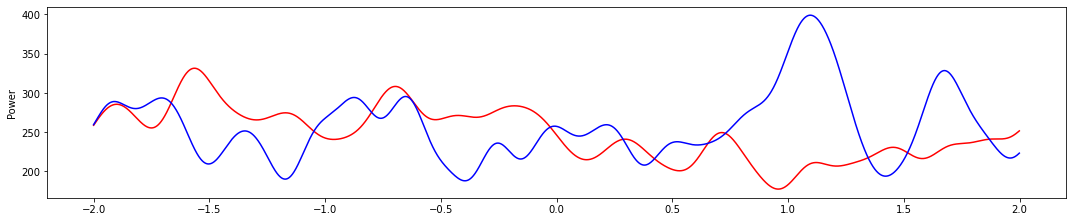

In [23]:
# plotting
# ghost_ci = [1.96 * np.std(x)/np.sqrt(len(x)) for x in np.transpose(ghost_trial_power_elec_J6_J7)]
# no_ghost_ci = [1.96 * np.std(x)/np.sqrt(len(x)) for x in np.transpose(ghost_trial_power_elec_J6_J7)]

# plotting
plt.figure(figsize=(15,6))
plt.subplot(2,1,1)
plt.plot(t,ghost_trial_power_elec_J6_J7[:, :, 3000:7000].mean(axis = 0).mean(axis = 0),  ms=1, color = 'red')
# plt.fill_between(t, (ghost_trial_power_elec_J6_J7[:, 3000:7000].mean(axis = 0)-ghost_ci[3000:7000]), (ghost_trial_power_elec_J6_J7[:, 3000:7000].mean(axis = 0)+ghost_ci[3000:7000]), color='red', alpha=.1)
plt.plot(t,no_ghost_trial_power_elec_J6_J7[:, :, 3000:7000].mean(axis = 0).mean(axis = 0),  ms=1, color = 'blue')
# plt.fill_between(t, (no_ghost_trial_power_elec_J6_J7[:, 3000:7000].mean(axis = 0)-no_ghost_ci[3000:7000]), (no_ghost_trial_power_elec_J6_J7[:, 3000:7000].mean(axis = 0)+no_ghost_ci[3000:7000]), color='blue', alpha=.1)
plt.ylabel('Power')
plt.tight_layout()

z-scoring to baseline


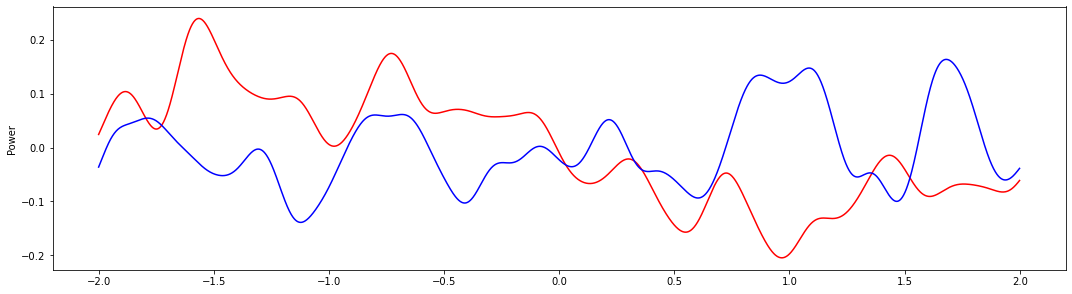

In [33]:
print('z-scoring to baseline')
bmean = ghost_trial_power_elec_J6_J7[:, :, 3000:7000].mean(axis=(0, 2),keepdims=True)
bstd = ghost_trial_power_elec_J6_J7[:, :, 3000:7000].std(axis=(0, 2),keepdims=True)
ghost_trial_power_elec_J6_J7_zscore = (ghost_trial_power_elec_J6_J7.copy() - bmean) / bstd


bmean = no_ghost_trial_power_elec_J6_J7[:, :, 3000:7000].mean(axis=(0, 2),keepdims=True)
bstd = no_ghost_trial_power_elec_J6_J7[:, :, 3000:7000].std(axis=(0, 2),keepdims=True)
no_ghost_trial_power_elec_J6_J7_zscore = (no_ghost_trial_power_elec_J6_J7.copy() - bmean) / bstd

# # ghost_ci = [1.96 * np.std(x)/np.sqrt(len(x)) for x in np.transpose(ghost_trial_power_elec_J6_J7_zscore)]
# # no_ghost_ci = [1.96 * np.std(x)/np.sqrt(len(x)) for x in np.transpose(no_ghost_trial_power_elec_J6_J7_zscore)]

# plotting
plt.figure(figsize=(15,8))
plt.subplot(2,1,1)
plt.plot(t,ghost_trial_power_elec_J6_J7_zscore[:, :, 3000:7000].mean(axis = 0).mean(axis = 0),  ms=1, color = 'red')
# plt.fill_between(t, (ghost_trial_power_elec_J6_J7_zscore[:, 3000:7000].mean(axis = 0)-ghost_ci[3000:7000]), (ghost_trial_power_elec_J6_J7_zscore[:, 3000:7000].mean(axis = 0)+ghost_ci[3000:7000]), color='red', alpha=.1)
plt.plot(t,no_ghost_trial_power_elec_J6_J7_zscore[:, :, 3000:7000].mean(axis = 0).mean(axis = 0),  ms=1, color = 'blue')
# plt.fill_between(t, (no_ghost_trial_power_elec_J6_J7_zscore[:, 3000:7000].mean(axis = 0)-no_ghost_ci[3000:7000]), (no_ghost_trial_power_elec_J6_J7_zscore[:, 3000:7000].mean(axis = 0)+no_ghost_ci[3000:7000]), color='blue', alpha=.1)
plt.ylabel('Power')
plt.tight_layout()

z-scoring to baseline


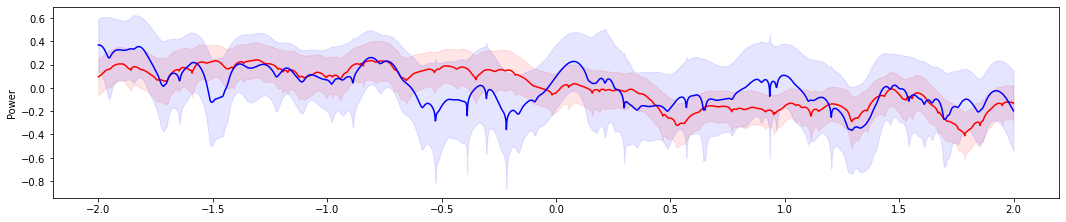

In [67]:
print('z-scoring to baseline')
ghost_trial_power_elec_J6_J7_log = np.log(ghost_trial_power_elec_J6_J7)
bmean = ghost_trial_power_elec_J6_J7_log[:,3000:7000].mean(axis=(0,1),keepdims=True)
bstd = ghost_trial_power_elec_J6_J7_log[:,3000:7000].std(axis=(0,1),keepdims=True)
ghost_trial_power_elec_J6_J7_logzscore = (ghost_trial_power_elec_J6_J7_log.copy() - bmean) / bstd

no_ghost_trial_power_elec_J6_J7_log = np.log(no_ghost_trial_power_elec_J6_J7)
bmean = no_ghost_trial_power_elec_J6_J7_log[:,3000:7000].mean(axis=(0,1),keepdims=True)
bstd = no_ghost_trial_power_elec_J6_J7_log[:,3000:7000].std(axis=(0,1),keepdims=True)
no_ghost_trial_power_elec_J6_J7_logzscore = (no_ghost_trial_power_elec_J6_J7_log.copy() - bmean) / bstd

ghost_ci = [1.96 * np.std(x)/np.sqrt(len(x)) for x in np.transpose(ghost_trial_power_elec_J6_J7_logzscore)]
no_ghost_ci = [1.96 * np.std(x)/np.sqrt(len(x)) for x in np.transpose(no_ghost_trial_power_elec_J6_J7_logzscore)]

# plotting
plt.figure(figsize=(15,6))
plt.subplot(2,1,1)
plt.plot(t,ghost_trial_power_elec_J6_J7_logzscore[:, 3000:7000].mean(axis = 0),  ms=1, color = 'red')
plt.fill_between(t, (ghost_trial_power_elec_J6_J7_logzscore[:, 3000:7000].mean(axis = 0)-ghost_ci[3000:7000]), (ghost_trial_power_elec_J6_J7_logzscore[:, 3000:7000].mean(axis = 0)+ghost_ci[3000:7000]), color='red', alpha=.1)
plt.plot(t,no_ghost_trial_power_elec_J6_J7_logzscore[:, 3000:7000].mean(axis = 0),  ms=1, color = 'blue')
plt.fill_between(t, (no_ghost_trial_power_elec_J6_J7_logzscore[:, 3000:7000].mean(axis = 0)-no_ghost_ci[3000:7000]), (no_ghost_trial_power_elec_J6_J7_logzscore[:, 3000:7000].mean(axis = 0)+no_ghost_ci[3000:7000]), color='blue', alpha=.1)
plt.ylabel('Power')
plt.tight_layout()

In [44]:
(ghost_trial_power_elec_J6_J7_logzscore[:, 3000:7000]-ghost_ci[3000:7000]).shape

(143, 4000)

In [155]:


np.savetxt("trial_theta_power_elec_J6_J7_SLCH002.csv", trial_power_elec_J6_J7, delimiter=",")

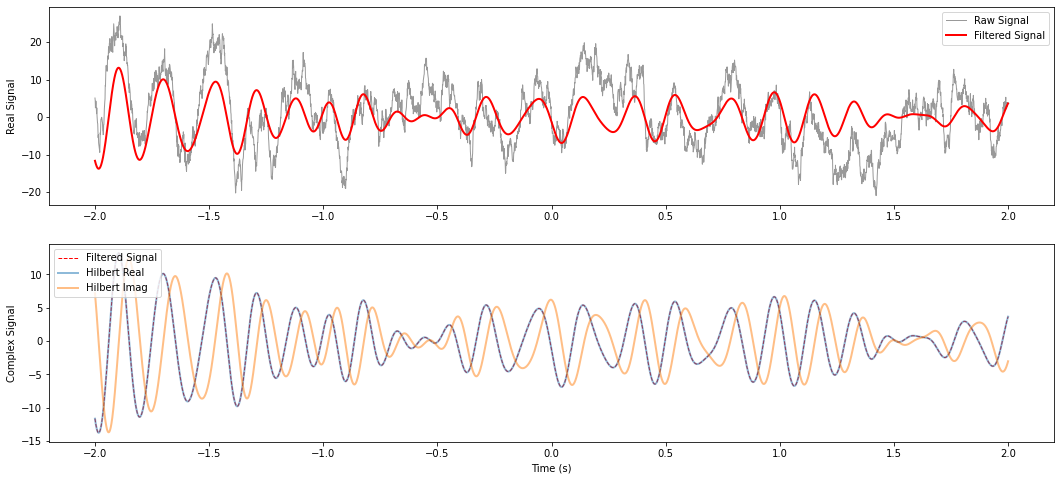

In [143]:
t = np.arange(len(ghost_hc_elec_trial))/1000 -5

plt.figure(figsize=(18,8))
plt.subplot(2,1,1)
plt.plot(t[3000:7000],ghost_hc_elec_trial[3000:7000], 'k', label='Raw Signal', alpha=0.4, lw=1)
plt.plot(t[3000:7000],x_filt[3000:7000], 'r', label='Filtered Signal', lw=2)
plt.ylabel('Real Signal')
plt.legend()

plt.subplot(2,1,2)
plt.plot(t[3000:7000],x_filt[3000:7000], '--r', label='Filtered Signal', alpha=1, lw=1)
plt.plot(t[3000:7000],x_a.real[3000:7000], label='Hilbert Real', alpha=0.5, lw=2)
plt.plot(t[3000:7000],x_a.imag[3000:7000], label='Hilbert Imag', alpha=0.5, lw=2)
plt.xlabel('Time (s)')
plt.ylabel('Complex Signal')
plt.legend(loc='upper left')


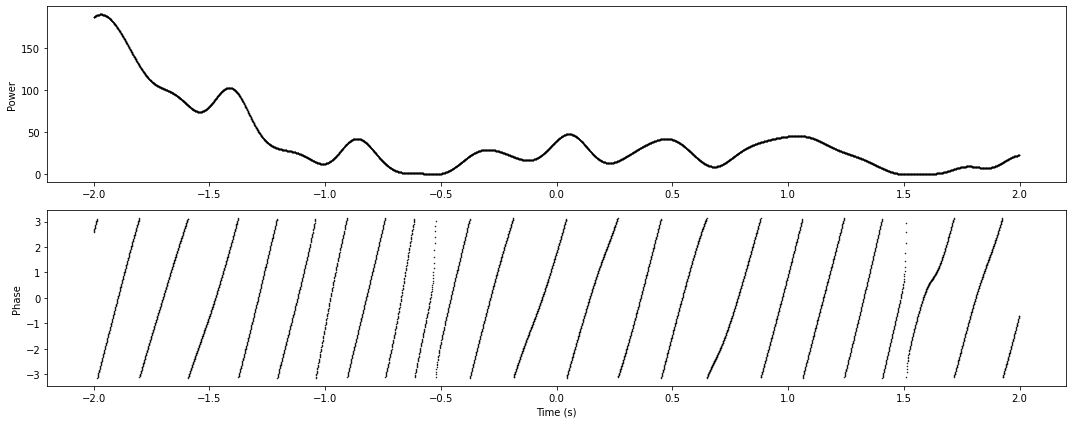

In [152]:
# t = t[3000:7000]

x_power = trial_power_elec_J6_J7[123, 3000:7000]

# plotting
plt.figure(figsize=(15,6))
plt.subplot(2,1,1)
plt.plot(t,x_power, '.k', ms=1)
plt.ylabel('Power')


plt.subplot(2,1,2)
plt.plot(t,x_phase, '.k', ms=1)
plt.ylabel('Phase')
plt.xlabel('Time (s)')
yb = plt.ylim()

plt.tight_layout()